# Running SNPGenie on H5N1 data

May 10, 2018 and December 8, 2017

Popoolation is not a great program for our purposes. I have known this for awhile, but it has always suited our needs well enough that I haven't looked elsewhere. However, now that I would like to do some comparisons of calculating pi at different SNP frequency cutoffs, I need something else. Chase Nelson's program, SNPGenie does this and so I am going to try to get that to work for me. There seem to be a few quirks with it that I will need to work around: 

1. SNPGenie only works on 1 gene segment at a time. This is a huge drag. It needs to be run 8 separate times for 1 influenza genome. I also figured out that for each genome, you need to provide a vcf that contains only sites from that gene, a gtf file with only coordinates for that cds, and a reference fasta with only that sequence. 

2. The vcf format options provided are quite close to what I need, but not quite. Varscan output is almost exactly the same as vcf option 4. The only difference is that SNPGenie assumes AD (allele depth) to be the number of reads supporting the reference base, when in varscan, it supports the number of reads for the alternative allele. Additionally, instead of having the reference base reads in 1 column and the alternative allele reads in another, SNPGenie would like them in the same column, separate by a comma. 

3. SNPGenie will not over-write old folders. So if I want everything in 1 folder, I will need to make new names for them as we proceed.

I will need to do several things in order to make SNPGenie work.

1. Fix the AD column issue/reformat my vcfs to accomodate that change. 
2. Automate splitting up vcf files, reference fasta files, and gtf files. 
3. Take care of automatic renaming of folders. 

In [34]:
# import necessary modules
import sys, subprocess, glob, os, shutil, re, importlib, Bio, csv
from subprocess import call
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import rpy2
%load_ext rpy2.ipython 

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## 1. Fix AD column issue and split vcf by gene

In [85]:
# set working directory
directory = "seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/"

In [86]:

# function to format VCF files for SNPgenie
def format_vcfs_for_snpgenie(vcf_file, directory):
    with open(vcf_file, "r") as csvfile:
        reader = csv.reader(csvfile, delimiter="\t")
        
        # get a list of the genes that have SNPs in the original, combined vcf file
        genes = []
        sample_name = os.path.basename(vcf_file).replace(".vcf", "")  # Extract the sample name
        
        for row in reader: 
            if "#" not in row[0] and "##" not in row[0]:
                gene = row[0]
                
                if gene.split("_")[-1:] == ['MP']:
                    genes.append(gene.replace("MP","M1"))
                    genes.append(gene.replace("MP","M2"))
                elif gene.split("_")[-1:] == ['NS']:
                    genes.append(gene.replace("NS","NS1"))
                    genes.append(gene.replace("NS","NEP"))
                else:
                    genes.append(gene)
        genes = set(genes)
        
        # Create empty output files for each gene and sample name
        for gene in genes:
            output_filename = f"{sample_name}_{gene}.vcf"
            with open(os.path.join(directory, output_filename), "w") as outfile:
                outfile.write("")
                
    # Re-open and loop through the VCF again to write the data
    with open(vcf_file, "r") as infile:
        for line in infile:
            # If it's a comment line, write it out to all of the output files
            if "#" in line or "##" in line:
                for gene in genes:
                    output_filename = f"{sample_name}_{gene}.vcf"
                    with open(os.path.join(directory, output_filename), "a") as outfile:
                        outfile.write(line)
            
            # If it's a SNP line, add in the AD annotation and write out to the appropriate file
            else: 
                gene = line.split("\t")[0]
                fix = line.split("\t")[9]
                ref_reads = fix.split(":")[4]
                alt_reads = fix.split(":")[5]
                new_depth = ref_reads + "," + alt_reads
                first_part = fix.split(":")[0:5]
                first_part = ":".join(first_part)
                second_part = fix.split(":")[6:14]
                second_part = ":".join(second_part)
                fixed = first_part + ":" + new_depth + ":" + second_part
                
                # Combine into a new line
                new_line = line.replace(fix, fixed)
                
                if gene.split("_")[-1:] == ['MP']:
                    with open(os.path.join(directory, f"{sample_name}_{gene.replace('MP', 'M1')}.vcf"), "a") as outfile:
                        outfile.write(new_line)
                    with open(os.path.join(directory, f"{sample_name}_{gene.replace('MP', 'M2')}.vcf"), "a") as outfile:
                        outfile.write(new_line)
                        
                elif gene.split("_")[-1:] == ['NS']:
                    with open(os.path.join(directory, f"{sample_name}_{gene.replace('NS', 'NS1')}.vcf"), "a") as outfile:
                        outfile.write(new_line)
                    with open(os.path.join(directory, f"{sample_name}_{gene.replace('NS', 'NEP')}.vcf"), "a") as outfile:
                        outfile.write(new_line)
                  
                else:
                    with open(os.path.join(directory, f"{sample_name}_{gene}.vcf"), "a") as outfile:
                        outfile.write(new_line)


In [87]:
# Get list of all VCF files in the directory
vcfs = []
for f in glob.glob(directory + "*.vcf"):
    vcfs.append(f)


In [88]:
vcfs

['seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/bv_w1_replicate-1_shared.vcf',
 'seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/ms_w2_replicate-2_shared.vcf',
 'seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/kc_com6_replicate-2_shared.vcf',
 'seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/cg_w2_replicate-1_shared.vcf',
 'seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/cb_com2_replicate-2_shared.vcf',
 'seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/bv_w6_replicate-1_shared.vcf',
 'seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/g_com2_replicate-1_shared.vcf',
 'seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/rth_w3_replicate-2_shared.vcf',
 'seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/gf_w3_replicate-1_shared.vcf',
 'seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/kc_com1_replicate-2_shared.vcf',
 'seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/be_w1_replicate-1_shared.vcf',
 'seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/wws_w1_replicate-1_shared.v

In [89]:
# Directory where you want to store the output files (e.g., parsed VCFs)
output_directory = '/Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/sample_vcfs/shared_vars_vcf/parsed/'

# Run the VCF formatting function on each VCF file
for vcf in vcfs: 
    format_vcfs_for_snpgenie(vcf, output_directory)

In [90]:
##get file list for everytthing

file_list = []

# Search for all VCF files within subdirectories of output_directory
for f in glob.glob(os.path.join(output_directory, "**", "*.vcf"), recursive=True):
    # Extract the filename without extension
    sample_name = os.path.basename(f).replace(".vcf", "")
    file_list.append(sample_name)

print(file_list)


['wws_w1_replicate-2_shared_pa', 'blvu_chester_replicate-2_shared_pb2', 'cb_com1_replicate-1_shared_ns', 'ms_w1_replicate-1_shared_pb2', 'tv_w1_replicate-2_shared_pb2', 'f_w1_replicate-2_shared_ha', 'gf_w1_replicate-2_shared_np', 'gf_w3_replicate-1_shared_ha', 'cg_w1_replicate-1_shared_ns', 'cb_com4_replicate-1_shared_pb1', 'f_w1_replicate-2_shared_pb2', 'bv_w7_replicate-1_shared_pb2', 'gf_w1_replicate-2_shared_pb1', 'cb_com2_replicate-2_shared_pb2', 'bv_w6_replicate-2_shared_ha', 'bv_w4_replicate-1_shared_np', 'wws_w1_replicate-1_shared_ha', 'blvu_chester_replicate-2_shared_pb1', 'bv_w3_replicate-1_shared_na', 'kc_com6_replicate-1_shared_pa', 'bv_w1_replicate-2_shared_pa', 'cb_com1_replicate-1_shared_np', 'bv_w3_replicate-2_shared_ns', 'cb_com3_replicate-2_shared_ha', 'ms_w1_replicate-1_shared_pb1', 'gf_w1_replicate-1_shared_na', 'bv_w1_replicate-2_shared_pb2', 'rth_w2_replicate-1_shared_ha', 'bv_w4_replicate-2_shared_na', 'kc_com1_replicate-2_shared_pa', 'kc_com3_replicate-2_shared_n

In [47]:
##format gtfs and fastas

##renaming reference gtfs and fastas
base_directory = "/Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference"  # Change this to your main directory

for root, _, files in os.walk(base_directory):
    subdir_name = os.path.basename(root)  # Get the subdirectory name

    for filename in files:
        if filename.startswith("."):  # Ignore hidden/system files
            continue

        file_extension = os.path.splitext(filename)[-1]  # Extract file extension
        
        if "reference" in filename:
            new_name = filename.replace("reference", subdir_name)  # Replace 'reference' with subdirectory name
            old_path = os.path.join(root, filename)
            new_path = os.path.join(root, new_name)

            os.rename(old_path, new_path)
            print(f"Renamed in {root}: {filename} → {new_name}")


Renamed in /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/ns: reference.gb → ns.gb
Renamed in /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/ns: reference.gtf → ns.gtf
Renamed in /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/ns: reference.fasta → ns.fasta
Renamed in /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/na: reference.gb → na.gb
Renamed in /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/na: reference.gtf → na.gtf
Renamed in /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/na: reference.fasta → na.fasta
Renamed in /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/pb2: reference.gb → pb2.gb
Renamed in /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SN

In [48]:
# Define the base directory where subdirectories are located
base_directory = "/Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/"

# Find all .fasta and .gtf files within subdirectories
fasta_files = glob.glob(os.path.join(base_directory, "*", "*.fasta"))
gtf_files = glob.glob(os.path.join(base_directory, "*", "*.gtf"))

# Move files to the base directory
for file_path in fasta_files + gtf_files:
    filename = os.path.basename(file_path)  # Get the file name
    destination = os.path.join(base_directory, filename)  # Define new path

    # Move file to base directory
    shutil.move(file_path, destination)
    print(f"Moved {file_path} → {destination}")

print("All .fasta and .gtf files have been moved to the base directory.")


Moved /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/ns/ns.fasta → /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/ns.fasta
Moved /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/na/na.fasta → /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/na.fasta
Moved /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/pb2/pb2.fasta → /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/pb2.fasta
Moved /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/pa/pa.fasta → /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/pa.fasta
Moved /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/reference/ha/ha.fasta → /Users/asjaeger/Desktop/project_s

In [49]:
import os
from subprocess import call

# Define the specific output directory where results will go
output_directory = "/Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/sample_vcfs_test/"
os.makedirs(output_directory, exist_ok=True)

# Define the base path for the reference FASTA and GTF files
reference_base_path = "/Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/parsed_vcf/reference/"

# Define the mapping between sample suffixes and reference file names
reference_mapping = {
    'pa': 'pa',  # Reference files for 'pa' samples
    'pb1': 'pb1',  # Reference files for 'pb1' samples
    'pb2': 'pb2',  # Reference files for 'pb2' samples
    'ha': 'ha',  # Reference files for 'ha' samples
    'np': 'np',  # Reference files for 'np' samples
    'ns': 'ns',  # Reference files for 'ns' samples
    'na': 'na',  # Reference files for 'na' samples
}

# Run SNPGenie for each VCF file in the file list
for vcf in file_list:
    # Extract the sample suffix (e.g., 'pa', 'pb1', 'ha' etc. from sample name)
    sample_suffix = vcf.split('_')[-1]  # Assuming the format ends with 'pa', 'pb1', etc.

    # Check if the sample_suffix has a valid mapping
    if sample_suffix in reference_mapping:
        reference_name = reference_mapping[sample_suffix]

        # Construct the paths to the reference FASTA and GTF files
        reference_fasta = os.path.join(reference_base_path, f"{reference_name}.fasta")
        reference_gtf = os.path.join(reference_base_path, f"{reference_name}.gtf")

        # Check if the reference files exist (optional, for error handling)
        if not os.path.exists(reference_fasta) or not os.path.exists(reference_gtf):
            print(f"Warning: Missing reference files for {sample_suffix}. Skipping {vcf}.")
            continue

        # Construct the path to the VCF file (make sure to specify the correct path to your VCF files)
        vcf_file = os.path.join('/Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/parsed_vcf/', f"{vcf}.vcf")
        
        # Check if the VCF file exists
        if not os.path.exists(vcf_file):
            print(f"VCF file missing for {vcf}. Skipping.")
            continue

        # Define the SNPGenie output directory for the sample
        snpgenie_output_dir = os.path.join(output_directory, f"{vcf}_results/")
        os.makedirs(snpgenie_output_dir, exist_ok=True)

        # Define the SNPGenie command
        snpgenie_command = f"perl /Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/snpgenie.pl --minfreq=0.01 --snpreport={vcf_file} --fastafile={reference_fasta} --gtffile={reference_gtf} --vcfformat=4"

        # Execute the SNPGenie command
        print(f"Running SNPGenie for {vcf}...")
        call(snpgenie_command, shell=True)

        # Move SNPGenie results to the specific output folder (if applicable)
        # Assuming SNPGenie generates a directory named SNPGenie_Results by default
        call(f"mv SNPGenie_Results {snpgenie_output_dir}", shell=True)
        
        print(f"Results for {vcf} saved in {snpgenie_output_dir}")
    else:
        print(f"No reference mapping found for sample suffix {sample_suffix}. Skipping.")


Running SNPGenie for be_w2_replicate-1_pa...


################################################################################
##                                                                            ##
##                             SNPGenie Initiated!                            ##
##                                                                            ##
################################################################################

  ###############################  LICENSE:  #################################
  ##            SNPGenie Copyright (C) 2015-19 Chase W. Nelson              ##
  ##            This program comes with ABSOLUTELY NO WARRANTY;             ##
  ##     This is free software, and you are welcome to redistribute it      ##
  ##               under certain conditions; see LICENSE.txt.               ##
  ############################################################################

WORKING_DIRECTORY=/Users/asjaeger/Desktop/project_source/hpai_PA
RESULTS



## WARNING: The CDS coordinates for gene PA-X in the gtf file do not yield a set of complete codons,
## or are absent from the file. The number of nucleotides must be a multiple of 3.
## SNPGenie terminated.





################################################################################
##                                                                            ##
##                             SNPGenie Initiated!                            ##
##                                                                            ##
################################################################################

  ###############################  LICENSE:  #################################
  ##            SNPGenie Copyright (C) 2015-19 Chase W. Nelson              ##
  ##            This program comes with ABSOLUTELY NO WARRANTY;             ##
  ##     This is free software, and you are welcome to redistribute it      ##
  ##               under certain conditions; see LICENSE.txt.               ##
  ############################################################################

WORKING_DIRECTORY=/Users/asjaeger/Desktop/project_source/hpai_PA
RESULTS_DIRECTORY=/Users/asjaeger/Desktop/project_so



## WARNING: The CDS coordinates for gene PA-X in the gtf file do not yield a set of complete codons,
## or are absent from the file. The number of nucleotides must be a multiple of 3.
## SNPGenie terminated.



## WARNING: The CDS coordinates for gene NEP in the gtf file do not yield a set of complete codons,
## or are absent from the file. The number of nucleotides must be a multiple of 3.
## SNPGenie terminated.





################################################################################
##                                                                            ##
##                             SNPGenie Initiated!                            ##
##                                                                            ##
################################################################################

  ###############################  LICENSE:  #################################
  ##            SNPGenie Copyright (C) 2015-19 Chase W. Nelson              ##
  ##            This program comes with ABSOLUTELY NO WARRANTY;             ##
  ##     This is free software, and you are welcome to redistribute it      ##
  ##               under certain conditions; see LICENSE.txt.               ##
  ############################################################################

WORKING_DIRECTORY=/Users/asjaeger/Desktop/project_source/hpai_PA
RESULTS_DIRECTORY=/Users/asjaeger/Desktop/project_so



## WARNING: The CDS coordinates for gene NP in the gtf file do not yield a set of complete codons,
## or are absent from the file. The number of nucleotides must be a multiple of 3.
## SNPGenie terminated.



## WARNING: The CDS coordinates for gene NP in the gtf file do not yield a set of complete codons,
## or are absent from the file. The number of nucleotides must be a multiple of 3.
## SNPGenie terminated.





################################################################################
##                                                                            ##
##                             SNPGenie Initiated!                            ##
##                                                                            ##
################################################################################

  ###############################  LICENSE:  #################################
  ##            SNPGenie Copyright (C) 2015-19 Chase W. Nelson              ##
  ##            This program comes with ABSOLUTELY NO WARRANTY;             ##
  ##     This is free software, and you are welcome to redistribute it      ##
  ##               under certain conditions; see LICENSE.txt.               ##
  ############################################################################

WORKING_DIRECTORY=/Users/asjaeger/Desktop/project_source/hpai_PA
RESULTS_DIRECTORY=/Users/asjaeger/Desktop/project_so



## WARNING: The CDS coordinates for gene NEP in the gtf file do not yield a set of complete codons,
## or are absent from the file. The number of nucleotides must be a multiple of 3.
## SNPGenie terminated.



## WARNING: The CDS coordinates for gene PA-X in the gtf file do not yield a set of complete codons,
## or are absent from the file. The number of nucleotides must be a multiple of 3.
## SNPGenie terminated.





################################################################################
##                                                                            ##
##                             SNPGenie Initiated!                            ##
##                                                                            ##
################################################################################

  ###############################  LICENSE:  #################################
  ##            SNPGenie Copyright (C) 2015-19 Chase W. Nelson              ##
  ##            This program comes with ABSOLUTELY NO WARRANTY;             ##
  ##     This is free software, and you are welcome to redistribute it      ##
  ##               under certain conditions; see LICENSE.txt.               ##
  ############################################################################

WORKING_DIRECTORY=/Users/asjaeger/Desktop/project_source/hpai_PA
RESULTS_DIRECTORY=/Users/asjaeger/Desktop/project_so



## WARNING: The CDS coordinates for gene NP in the gtf file do not yield a set of complete codons,
## or are absent from the file. The number of nucleotides must be a multiple of 3.
## SNPGenie terminated.



## WARNING: The CDS coordinates for gene NEP in the gtf file do not yield a set of complete codons,
## or are absent from the file. The number of nucleotides must be a multiple of 3.
## SNPGenie terminated.





################################################################################
##                                                                            ##
##                             SNPGenie Initiated!                            ##
##                                                                            ##
################################################################################

  ###############################  LICENSE:  #################################
  ##            SNPGenie Copyright (C) 2015-19 Chase W. Nelson              ##
  ##            This program comes with ABSOLUTELY NO WARRANTY;             ##
  ##     This is free software, and you are welcome to redistribute it      ##
  ##               under certain conditions; see LICENSE.txt.               ##
  ############################################################################

WORKING_DIRECTORY=/Users/asjaeger/Desktop/project_source/hpai_PA
RESULTS_DIRECTORY=/Users/asjaeger/Desktop/project_so

In [51]:
import os
from subprocess import call
import glob

# Define the base output directory where SNPGenie results are stored
output_directory = "/Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/sample_vcfs_test/"

# Get unique sample names (excluding gene names)
unique_samples = set("_".join(sample.split("_")[:-1]) for sample in file_list)

# Organize results by sample
for sample in unique_samples:
    # Define the sample-level directory
    sample_dir = os.path.join(output_directory, sample)
    os.makedirs(sample_dir, exist_ok=True)  # Ensure sample-level directory exists

    # Find all gene-specific result directories that belong to this sample
    gene_result_dirs = glob.glob(os.path.join(output_directory, f"{sample}_*_results"))

    # Move gene result directories into the sample-level directory
    for gene_dir in gene_result_dirs:
        if os.path.isdir(gene_dir):  # Ensure it's a directory
            call(f"mv {gene_dir} {sample_dir}/", shell=True)  # Move it inside the sample directory

    # Compile all product_results.txt files into a single file within the sample directory
    combined_results_file = os.path.join(sample_dir, "combined_product_results.txt")

    header_written = False  # Flag to track if header is written

    with open(combined_results_file, "w") as outfile:
        for gene_dir in gene_result_dirs:
            product_results_file = os.path.join(sample_dir, os.path.basename(gene_dir), "SNPGenie_Results/product_results.txt")

            if os.path.exists(product_results_file):  # Check if file exists
                with open(product_results_file, "r") as infile:
                    lines = infile.readlines()
                    
                    # Write header only once (from the first file)
                    if not header_written:
                        outfile.write(lines[0])  # Write header
                        header_written = True
                    
                    # Write the rest of the file (excluding header)
                    outfile.writelines(lines[1:])
    
    print(f"Organized results and saved combined results for: {sample}")


Organized results and saved combined results for: be_w1_replicate-1
Organized results and saved combined results for: be_w1_replicate-2
Organized results and saved combined results for: be_w2_replicate-1


In [52]:
# Find all sample directories
sample_dirs = [d for d in os.listdir(output_directory) if os.path.isdir(os.path.join(output_directory, d))]

for sample in sample_dirs:
    combined_results_file = os.path.join(output_directory, sample, "combined_product_results.txt")

    if os.path.exists(combined_results_file):  # Check if file exists
        with open(combined_results_file, "r") as infile:
            lines = infile.readlines()

        # Process file to replace the first column with the sample name
        with open(combined_results_file, "w") as outfile:
            header_written = False

            for i, line in enumerate(lines):
                split_line = line.strip().split("\t")

                if i == 0:
                    # Keep the header unchanged
                    outfile.write(line)
                    header_written = True
                elif len(split_line) > 1:
                    # Replace first column with sample name
                    split_line[0] = sample
                    outfile.write("\t".join(split_line) + "\n")

        print(f"Updated file column for: {sample}")


Updated file column for: be_w1_replicate-2
Updated file column for: be_w1_replicate-1
Updated file column for: be_w2_replicate-1


## Split gtfs and fastas by gene

In [9]:
# # split up fasta files

# for fasta in fastas:
#     with open(fasta, "r") as infile: 
#         for seq in SeqIO.parse(infile, "fasta"):
#             name = seq.description
#             sequence = str(seq.seq)
        
#             if name.endswith("MP"):
#                 with open(directory + name.replace("MP","M1") + ".fasta", "w") as outfile:
#                     outfile.write(">" + name.replace("MP","M1") + "\n")
#                     outfile.write(sequence) 
#                 with open(directory + name.replace("MP","M2") + ".fasta", "w") as outfile:
#                     outfile.write(">" + name.replace("MP","M2") + "\n")
#                     outfile.write(sequence)              
                    
#             elif name.endswith("NS"):
#                 with open(directory + name.replace("NS","NS1") + ".fasta", "w") as outfile:
#                     outfile.write(">" + name.replace("NS","NS1") + "\n")
#                     outfile.write(sequence) 
#                 with open(directory + name.replace("NS","NEP") + ".fasta", "w") as outfile:
#                     outfile.write(">" + name.replace("NS","NEP") + "\n")
#                     outfile.write(sequence) 
                    
#             else:
#                 with open(directory + name + ".fasta", "w") as outfile:
#                     outfile.write(">" + name + "\n")
#                     outfile.write(sequence) 

In [ ]:
# # split up gtf files 
# for gtf in gtfs: 
#     with open(gtf, "r") as infile:
#         for line in infile:
#             gene = line.split("\t")[0]
        
#             if gene.endswith("MP") and "\"M1\"" in line:
#                 with open(directory + gene.replace("MP","M1") + ".gtf", "a") as outfile:
#                         outfile.write(line)
            
#             elif gene.endswith("MP") and "\"M2\"" in line:
#                 with open(directory + gene.replace("MP","M2") + ".gtf", "a") as outfile:
#                     outfile.write(line)
                    
#             elif gene.endswith("NS") and "\"NS1\"" in line:
#                 with open(directory + gene.replace("NS","NS1") + ".gtf", "a") as outfile:
#                     outfile.write(line)
            
#             elif gene.endswith("NS") and "\"NEP\"" in line:
#                 with open(directory + gene.replace("NS","NEP") + ".gtf", "a") as outfile:
#                     outfile.write(line)
                    
#             else:
#                 with open(directory + gene + ".gtf", "a") as outfile:
#                     outfile.write(line)

In [80]:
gtfs = glob.glob("test_gtf_parse/*.gtf")  # Get all .gtf files

# Make sure 'gtfs' is a list of file paths
for gtf in gtfs:
    with open(gtf, "r") as infile:
        for line in infile:
            chrom = line.split("\t")[0]  # e.g., OL638146.1

            # Get gene_id from the attributes field (last column)
            attributes = line.strip().split("\t")[8]
            gene_id = None
            for field in attributes.split(";"):
                if "gene_id" in field:
                    gene_id = field.strip().split(" ")[1].replace('"', "")
                    break

            if not gene_id:
                continue  # skip if no gene_id found

            # Handle special cases for MP and NS segments
            if chrom.endswith("MP"):
                if gene_id == "M1":
                    outname = gene_id  # Use gene_id directly
                elif gene_id == "M2":
                    outname = gene_id  # Use gene_id directly
                else:
                    outname = gene_id  # Default to gene_id for MP cases
            elif chrom.endswith("NS"):
                if gene_id == "NS1":
                    outname = gene_id  # Use gene_id directly
                elif gene_id == "NEP":
                    outname = gene_id  # Use gene_id directly
                else:
                    outname = gene_id  # Default to gene_id for NS cases
            else:
                outname = gene_id  # Use gene_id for other cases

            # Write to a new file named after the gene_id
            output_dir = "test_gtf_parse/"  # Define the directory where you want to save files
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)  # Ensure the directory exists
            with open(os.path.join(output_dir, f"{outname}.gtf"), "a") as outfile:
                outfile.write(line)


In [79]:
print(directory)
print(type(directory))

seq/illumina-pipeline/for_SNPgenie/sample_vcfs_test/
<class 'str'>


### Consolidate files together into folders by sample name

In [11]:
# # make a list of file names, which are just the gene names that the gtf file, fasta file and vcf files share
# file_list = []
# for f in glob.glob(directory + "*.vcf"):
#     f = f.replace(".vcf","")
#     file_list.append(f)


In [12]:
# # consolidate fastas, vcfs, and gtfs all into 1 folder together 
# for f in file_list:
#     call("mkdir {f}".format(f=f), shell=True)
#     for n in glob.glob(directory + "*"):
#         if f in n:
#             call("mv {n} {f}".format(n=n,f=f), shell=True)

#### Note: 

At this point, there will be gtf and fasta files for genes that are not in folders. That is ok. That means that there were no SNPs called for that gene in that sample. 

In [13]:
# # run SNP Genie on all of these
# for f in file_list:
#     f1 = f.replace(directory, "")
#     call("snpgenie.pl --vcfformat=4 --gtffile={f}/{f1}.gtf --fastafile={f}/{f1}.fasta --snpreport={f}/{f1}.vcf".format(f=f,f1=f1),shell=True)
#     call("mv SNPGenie_Results {f}/".format(f=f,f1=f1), shell=True)

In [352]:
# # compile all of the output files from the various genes
# call("grep -i '' */SNPGenie_Results/product_results.txt >> combined.txt".format(directory=directory),shell=True)

0

In [53]:
# Output file
output_file = "seq/illumina-pipeline/for_SNPgenie/sample_vcfs_test/product_results_allgenes_allsamps.txt"

# Delete existing output file if present
if os.path.exists(output_file):
    os.remove(output_file)

# Track if we've written the header
header_written = False

# Get all combined.txt files in subdirectories
file_paths = sorted(glob.glob("**/combined_product_results.txt", recursive=True))

for file_path in file_paths:
    with open(file_path, "r") as f:
        lines = f.readlines()

    if not lines:
        continue  # skip empty files

    header, *data = lines

    with open(output_file, "a") as out:
        if not header_written:
            out.write(header)
            header_written = True
        out.writelines(data)

    print(f"Merged {file_path}")

print(f"✅ Done. Merged into {output_file}")


Merged seq/illumina-pipeline/for_SNPgenie/sample_vcfs_test/be_w1_replicate-1/combined_product_results.txt
Merged seq/illumina-pipeline/for_SNPgenie/sample_vcfs_test/be_w1_replicate-2/combined_product_results.txt
Merged seq/illumina-pipeline/for_SNPgenie/sample_vcfs_test/be_w2_replicate-1/combined_product_results.txt
✅ Done. Merged into product_results_allgenes_allsamps.txt


In [583]:
# # take out all of the unwanted lines from the combined file
# def cleanup_snpgenie_output(directory, infile):
#     with open(directory + infile, "r") as infile: 
#         linenumber = 0
#         for line in infile:
#             linenumber += 1
#             if linenumber == 1:
#                 new_line = line.split(":")[1]
#                 with open(directory + "combined_pi_formatted.txt", "a") as outfile:
#                     outfile.write(new_line)
        
#             elif "N_diffs" not in line:
#                 new_line = line.replace("/SNPGenie_Results/product_results.txt:temp_vcf4_Sample1.vcf","")
            
#                 genes = ["_PB2","_PB1","_PA","_H5","_NP","_N1","_M1","_M2","_NS1","_NEP"]
#                 for g in genes: 
#                     if g + "\t" in new_line:
#                         new_line2 = new_line.replace(g, "")
#                 with open(directory + "combined_pi_formatted.txt", "a") as outfile:
#                     outfile.write(new_line2)

In [584]:
# cleanup_snpgenie_output(directory, "combined.txt")

## Results:

This actually all worked really well! Except for the grep, which for some reason works totally fine in shell but isn't working for me when run from within this notebook. Otherwise though, things look good! I will now go through and see which genes didn't work/have empty values. 

In [60]:
with open("/Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/sample_vcfs_test/product_results_allgenes_allsamps.txt", "r") as f:
    for i in range(5):
        print(repr(f.readline()))

'file\tproduct\tN_diffs\tS_diffs\tN_diffs_vs_ref\tS_diffs_vs_ref\tN_sites\tS_sites\tpiN\tpiS\tmean_dN_vs_ref\tmean_dS_vs_ref\tmean_gdiv_polymorphic\tmean_N_gdiv\tmean_S_gdiv\n'
'be_w1_replicate-1\tNA\t0.0853980187327366\t0.0907949386651212\t0.0446096654275093\t0.0476190476190476\t1091.69640644362\t309.303593556382\t7.82250616826109e-05\t0.000293546342676328\t4.08627024548269e-05\t0.000153955688233436\t0.0879711171008575\t0.0852392863559099\t0.090702947845805\n'
'be_w1_replicate-1\tHA\t0.265355035769179\t0.178263169906338\t0.125038063631619\t0.0910180479947746\t1324.50435673024\t376.464064322391\t0.000200342893868807\t0.000473519750755492\t9.44036635261026e-05\t0.000241770879668424\t0.0341100099901029\t0.0331508513202019\t0.0356446638619444\n'
'be_w1_replicate-1\tPB1\t0.516780723002237\t0.173763677941048\t0.275539380691041\t0.0927385605512713\t1764.75758000292\t506.242419997088\t0.000292833831036092\t0.000343242034008228\t0.000156134408381794\t0.000183190022977144\t0.0985907556314371\t0

In [61]:
import pandas as pd

df = pd.read_table(
    "/Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/sample_vcfs_test/product_results_allgenes_allsamps.txt",
    sep="\t",
    na_values=["NA", "*"]  # treat both as NaN
)

# Optional: check if columns read correctly
print(df.dtypes)

# Fill missing 'product' values with 'neuram'
df['product'] = df['product'].fillna('neuram')

# Convert piN and piS to numeric (if not already)
df['piN'] = pd.to_numeric(df['piN'], errors='coerce')
df['piS'] = pd.to_numeric(df['piS'], errors='coerce')


file                      object
product                   object
N_diffs                  float64
S_diffs                  float64
N_diffs_vs_ref           float64
S_diffs_vs_ref           float64
N_sites                  float64
S_sites                  float64
piN                      float64
piS                      float64
mean_dN_vs_ref           float64
mean_dS_vs_ref           float64
mean_gdiv_polymorphic    float64
mean_N_gdiv              float64
mean_S_gdiv              float64
dtype: object


In [63]:
df.head(5)

,file,product,N_diffs,S_diffs,N_diffs_vs_ref,S_diffs_vs_ref,N_sites,S_sites,piN,piS,mean_dN_vs_ref,mean_dS_vs_ref,mean_gdiv_polymorphic,mean_N_gdiv,mean_S_gdiv
0,be_w1_replicate-1,neuram,0.085398,0.090795,0.044610,0.047619,1091.696406,309.303594,0.000078,0.000294,0.000041,0.000154,0.087971,0.085239,0.090703
1,be_w1_replicate-1,HA,0.265355,0.178263,0.125038,0.091018,1324.504357,376.464064,0.000200,0.000474,0.000094,0.000242,0.034110,0.033151,0.035645
2,be_w1_replicate-1,PB1,0.516781,0.173764,0.275539,0.092739,1764.757580,506.242420,0.000293,0.000343,0.000156,0.000183,0.098591,0.103339,0.086719
3,be_w1_replicate-1,PB1-F2,0.000000,0.000000,0.000000,0.000000,216.166667,53.833333,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
4,be_w1_replicate-1,PB2,0.362772,0.295541,0.152741,0.151378,1753.581936,517.321389,0.000207,0.000571,0.000087,0.000293,0.038718,0.036272,0.042213


## Data wrangling and plotting:

In [54]:
# # read in the SNPGenie pi results as a dataframe
# df = pd.read_table("/Users/asjaeger/Desktop/project_source/hpai_PA/seq/illumina-pipeline/for_SNPgenie/sample_vcfs_test/product_results_allgenes_allsamps.txt", sep="\t")
# df['product'] = df['product'].fillna('neuram')                                     # replace NA with neuram
# # df['species'] = np.where((df['file'].str.contains("duck")), "duck","human")        # add in a species column
# df.head()

,file,product,N_diffs,S_diffs,N_diffs_vs_ref,S_diffs_vs_ref,N_sites,S_sites,piN,piS,mean_dN_vs_ref,mean_dS_vs_ref,mean_gdiv_polymorphic,mean_N_gdiv,mean_S_gdiv
0,be_w1_replicate-1,neuram,0.085398,0.090795,0.044610,0.047619,1091.696406,309.303594,0.000078,0.000294,0.000041,0.000154,0.0879711171008575,0.0852392863559099,0.090702947845805
1,be_w1_replicate-1,HA,0.265355,0.178263,0.125038,0.091018,1324.504357,376.464064,0.000200,0.000474,0.000094,0.000242,0.0341100099901029,0.0331508513202019,0.0356446638619444
2,be_w1_replicate-1,PB1,0.516781,0.173764,0.275539,0.092739,1764.757580,506.242420,0.000293,0.000343,0.000156,0.000183,0.0985907556314371,0.103339395090085,0.0867191569848175
3,be_w1_replicate-1,PB1-F2,0.000000,0.000000,0.000000,0.000000,216.166667,53.833333,0.000000,0.000000,0.000000,0.000000,*,*,*
4,be_w1_replicate-1,PB2,0.362772,0.295541,0.152741,0.151378,1753.581936,517.321389,0.000207,0.000571,0.000087,0.000293,0.0387180552498716,0.0362719251297004,0.0422125268501162


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   file                   15 non-null     object 
 1   product                15 non-null     object 
 2   N_diffs                15 non-null     float64
 3   S_diffs                15 non-null     float64
 4   N_diffs_vs_ref         15 non-null     float64
 5   S_diffs_vs_ref         15 non-null     float64
 6   N_sites                15 non-null     float64
 7   S_sites                15 non-null     float64
 8   piN                    15 non-null     float64
 9   piS                    15 non-null     float64
 10  mean_dN_vs_ref         15 non-null     float64
 11  mean_dS_vs_ref         15 non-null     float64
 12  mean_gdiv_polymorphic  12 non-null     float64
 13  mean_N_gdiv            12 non-null     float64
 14  mean_S_gdiv            10 non-null     float64
dtypes: float

In [65]:
# Assuming your DataFrame is called df and has columns: 'product', 'piN', 'piS'

# Group by product and calculate mean piN and piS
grouped = df.groupby('product')[['piN', 'piS']].mean().reset_index()

# Calculate the ratio
grouped['piN/piS'] = grouped['piN'] / grouped['piS']

# View the result
print(grouped)


  product       piN       piS   piN/piS
0      HA  0.000185  0.000809  0.228970
1     PB1  0.000158  0.000212  0.747176
2  PB1-F2  0.000000  0.000000       NaN
3     PB2  0.000203  0.000446  0.456088
4  neuram  0.000175  0.000125  1.402513


In [67]:
# Group by 'product' and calculate both mean and std for piN and piS
grouped = df.groupby('product')[['piN', 'piS']].agg(['mean', 'std']).reset_index()


# Flatten MultiIndex columns
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]

# Rename for clarity
grouped.rename(columns={
    'piN_mean': 'piN_mean',
    'piN_std': 'piN_std',
    'piS_mean': 'piS_mean',
    'piS_std': 'piS_std'
}, inplace=True)

# Calculate the ratio of the means
grouped['piN/piS'] = grouped['piN_mean'] / grouped['piS_mean']

# View result
print(grouped)


  product  piN_mean   piN_std  piS_mean   piS_std   piN/piS
0      HA  0.000185  0.000135  0.000809  0.000881  0.228970
1     PB1  0.000158  0.000140  0.000212  0.000185  0.747176
2  PB1-F2  0.000000  0.000000  0.000000  0.000000       NaN
3     PB2  0.000203  0.000003  0.000446  0.000120  0.456088
4  neuram  0.000175  0.000141  0.000125  0.000152  1.402513


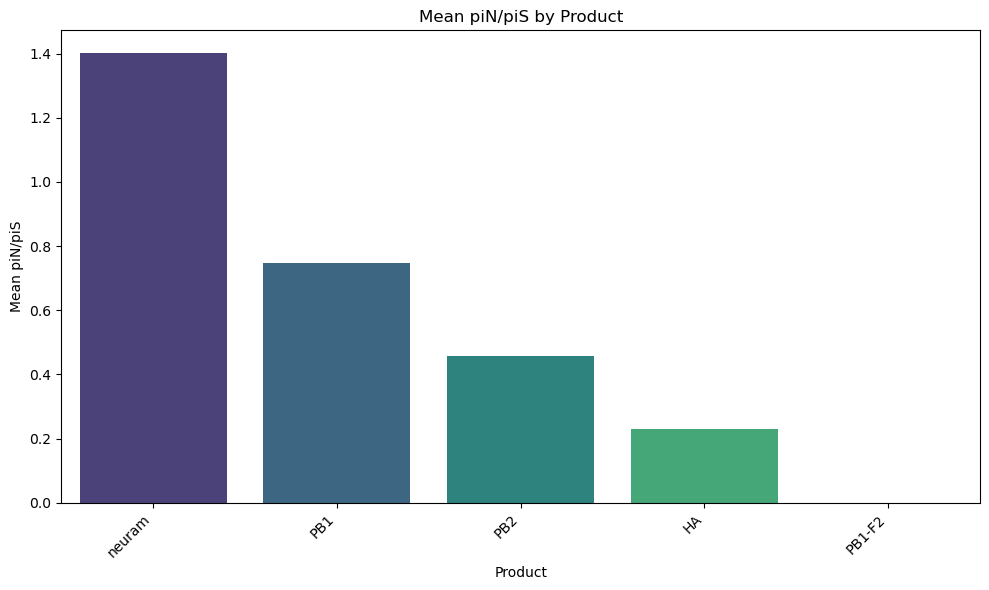

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by ratio if you want cleaner x-axis order
grouped_sorted = grouped.sort_values('piN/piS', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_sorted, x='product', y='piN/piS', hue = 'product', palette='viridis')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean piN/piS')
plt.xlabel('Product')
plt.title('Mean piN/piS by Product')
plt.tight_layout()
plt.show()


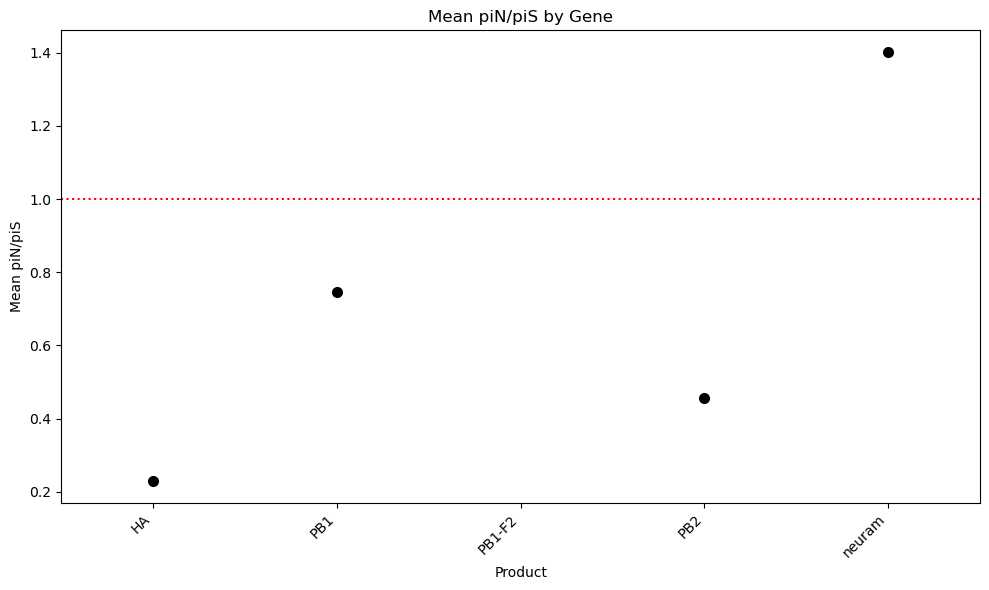

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.stripplot(data=grouped, x='product', y='piN/piS', size=8, color='black')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean piN/piS')
plt.xlabel('Product')
plt.title('Mean piN/piS by Gene')
plt.tight_layout()

plt.axhline(y=1, color='red', linestyle='dotted', linewidth=1.5)

plt.show()
##>1 = positive selection, <1 = purifying

In [587]:
# # cast the dataframe and calculate some mean values for piN 
# pS_h = df[df['species'] == 'human']
# pS_h = pS_h[['file','product','piS']]
# pS_h = pS_h.pivot(index='file', columns='product', values='piS')
# pS_h.index.name = None
# pS_h.columns.name = None
# pS_h = pS_h.fillna(0)
# pS_h.loc['mean'] = pS_h.mean()
# pS_h.loc['sd'] = pS_h.std()
# pS_means_h = pS_h.loc[['mean','sd']]
# pS_means_h = pS_means_h.transpose()
# pS_means_h["measure"] = "piS"
# pS_means_h["species"] = "human"

# pS_d = df[df['species'] == 'duck']
# pS_d = pS_d[['file','product','piS']]
# pS_d = pS_d.pivot(index='file', columns='product', values='piS')
# pS_d.index.name = None
# pS_d.columns.name = None
# pS_d = pS_d.fillna(0)
# pS_d.loc['mean'] = pS_d.mean()
# pS_d.loc['sd'] = pS_d.std()
# pS_means_d = pS_d.loc[['mean','sd']]
# pS_means_d = pS_means_d.transpose()
# pS_means_d["measure"] = "piS"
# pS_means_d["species"] = "duck"
# pS_means_d.head()

,mean,sd,measure,species
HA,0.000207,0.000397,piS,duck
M1,0.000000,0.000000,piS,duck
M2,0.000000,0.000000,piS,duck
NEP,0.000262,0.000380,piS,duck
NP,0.000237,0.000469,piS,duck


In [588]:
# combine the mean and stdev values for piN and piS into 1 dataframe 
df1 = pd.concat([pN_means_h, pN_means_d, pS_means_h, pS_means_d])
df1.reset_index(inplace=True)
df1.head()

,index,mean,sd,measure,species
0,HA,0.000253,0.000260,piN,human
1,M1,0.000033,0.000051,piN,human
2,M2,0.000123,0.000175,piN,human
3,NEP,0.000051,0.000113,piN,human
4,NP,0.000036,0.000055,piN,human


In [377]:
%%R -w 800 -h 500 -u px -i df1  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

df1$index = gsub("neuram", "NA", df1$index)
df1$gene = factor(df1$index, levels=c("PB2","PB1","PA","HA","NP","NA","M1","M2","NS1","NEP"))

p <- ggplot(data=df1, aes(x=gene, y=mean, fill=species)) + 
    geom_col(position="dodge", stat="identity")+
    geom_errorbar(data=df1, aes(x=gene, ymin=mean-sd, ymax=mean+sd, color=species),position=position_dodge(0.9), stat="identity")+
    facet_wrap(~measure, scales="free")+
    scale_fill_manual(values=c("#99bfaa","#5c3d46"))+
    scale_color_manual(values=c("#99bfaa","#5c3d46"))+
    labs(x="gene",y="diversity")+
    #ggtitle("number of shared sites in random simulations") + 
    scale_y_continuous(limits=c(-0.0006,0.002))+
    #scale_x_continuous(limits=c(0,500))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+theme(strip.text.x=element_text(size=11))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16, angle=90))+
    theme(legend.text=element_text(size=16))+theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("piN_and_piS_means-2018-05-10.pdf", p, width = 10, height = 5, device=pdf, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2018-05-08")

/Users/lmoncla/anaconda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  Ignoring unknown parameters: stat

  warnings.warn(x, RRuntimeWarning)


## Plot number of SNPs/site

I am starting to think that maybe using pi for this dataset isn't so great. I think that I am going to try out and see how it looks to just plot the overall number of nonsynonymous and synonymous SNPs per nonsynonymous or synonymou site per gene per species. I can read in the number of SNPs from the combined SNPs output file. For the number of synonymous and nonsynonymous sites, I need to count the samples in df (those that had a snp) but also those that did not. I think that the easiest way to do that will be to just run SNPGenie on a set of dummy data so that I can get the number of synonymous and nonsynonymous sites per gene per sample.  

### Step 1: Calculate the average number of synonymous and nonsynonymous sites per gene 

This will involve using the ones I already have plus generating fake vcf files so that I can run SNPGenie for the samples/genes that didn't have any SNPs. 


#### Generate dummy vcfs to get the number of nonsynonymous and synonymous sites for genes that don't have snps

In [589]:
missing_vcfs_directory = "/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/SNPGenie_diversity_estimates/1_percent_SNPs-2018-05-10/samples_and_genes_with_no_snps/"

In [590]:
samples = []
for f in glob.glob(missing_vcfs_directory + "*.gtf"):
    files.append(f)
    sample_name = f.replace(missing_vcfs_directory, "")
    sample_name = sample_name.replace(".gtf","")
    samples.append(sample_name)

In [591]:
# make fake vcf files for each sample 
for s in samples: 
    vcfname = missing_vcfs_directory + s + ".vcf"
    with open(vcfname, "w") as vcf: 
        vcf.write("#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\tSample1\n")
        vcf.write(s+"\t28\t.\tC\tT\t.\tPASS\tADP=147;WT=1000;HET=1;HOM=0;NC=0\tGT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:ADF:ADR\t0/1:37:147:147:135:135,12:8.16%:1.9326E-4:38:37:61:74:5:7\n")
        vcf.write(s+"\t100\t.\tC\tT\t.\tPASS\tADP=147;WT=1000;HET=1;HOM=0;NC=0\tGT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:ADF:ADR\t0/1:37:147:147:135:135,12:8.16%:1.9326E-4:38:37:61:74:5:7")

In [593]:
# consolidate fastas, vcfs, and gtfs all into 1 folder together 
for s in samples:
    call("mkdir {missing_vcfs_directory}{s}".format(missing_vcfs_directory=missing_vcfs_directory,s=s), shell=True)
    for n in glob.glob(missing_vcfs_directory + "*"):
        if s in n:
            call("mv {n} {missing_vcfs_directory}{s}".format(s=s, n=n,missing_vcfs_directory=missing_vcfs_directory), shell=True)

In [594]:
# run SNPgenie
for s in samples:
    call("snpgenie.pl --vcfformat=4 --gtffile={missing_vcfs_directory}{s}/{s}.gtf --fastafile={missing_vcfs_directory}{s}/{s}.fasta --snpreport={missing_vcfs_directory}{s}/{s}.vcf".format(missing_vcfs_directory=missing_vcfs_directory,s=s),shell=True)
    call("mv SNPGenie_Results {missing_vcfs_directory}{s}/".format(missing_vcfs_directory=missing_vcfs_directory,s=s), shell=True)

In [ ]:
# compile all of the output files from the various genes
call("grep -i '' */SNPGenie_Results/product_results.txt >> combined.txt".format(directory=directory),shell=True)

In [595]:
# clean up outfile
cleanup_snpgenie_output(missing_vcfs_directory, "combined.txt")

In [605]:
# read in the SNPGenie pi results as a dataframe
df_dummy_values = pd.read_table(missing_vcfs_directory + "combined_pi_formatted.txt", sep="\t")
df_dummy_values['product'] = df['product'].fillna('neuram')                                     # replace NA with neuram
df_dummy_values['species'] = np.where((df_dummy_values['file'].str.contains("duck")), "duck","human")        # add in a species column
df_dummy_values = df_dummy_values[['file','product','N_sites','S_sites','species']]
df_dummy_values = df_dummy_values.rename(index=str, columns={"file":'sample','product':'gene'})
df_dummy_values.head()
print(len(df_dummy_values))

42


In [606]:
# read in the values from the genes that did have SNPs
sites = df[['file','product','N_sites','S_sites','species']]
sites = sites.rename(index=str, columns={'file':'sample','product':'gene'})
sites.head()
print(len(sites))

78


In [607]:
# combine dummy and real data into 1 dataframe
sites2 = pd.concat([sites,df_dummy_values])
sites2 = sites2[['gene','N_sites','S_sites','species']]
sites2.head()

,gene,N_sites,S_sites,species
0,HA,1328.854414,372.145586,duck
1,NP,1145.707418,348.292582,duck
2,PB2,1751.833333,525.166667,duck
3,HA,1332.785015,371.214985,human
4,M1,576.666667,179.333333,human


In [608]:
# calculate the mean number of nonsynonymous and synonymous sites per gene per species and output that into a dataframe
genes = ['PB2','PB1','PA','HA','NP','neuram','M1','M2','NS1','NEP']
species = ['duck','human']
count = 0

for g in genes: 
    for s in species:
        count += 1
        subsetdf = sites2.loc[(sites2['gene'] == g) & (sites2['species'] == s)]
        subsetdf.loc['mean'] =  subsetdf.mean()
        subsetdf['gene'] = g
        subsetdf['species'] = s
        subsetdf = subsetdf.loc[['mean']]
        
        if count == 1:
            mean_sites_df = subsetdf
        else:
            mean_sites_df = pd.concat([subsetdf, means_df])

mean_sites_df['gene'] = mean_sites_df['gene'].str.replace("neuram","NA")
mean_sites_df.head()

/Users/lmoncla/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/lmoncla/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/lmoncla/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,gene,N_sites,S_sites,species
mean,NEP,286.101039,76.898961,human
mean,NEP,286.101039,76.898961,human
mean,NEP,285.992593,77.007407,duck
mean,NS1,520.724740,154.275260,human
mean,NS1,521.000000,154.000000,duck


In [609]:
# read in snps csv file and count the number of nonsynonymous and synonymous per gene per species

with open(snps_path, "r") as infile: 
    snps_dict = {}
    for line in infile: 
        if "reference_position" not in line:
            sample = line.split("\t")[0]
            sample = "_".join(sample.split("_")[:-1])
        
            if "duck" in sample:
                species = "duck"
            else:
                species = "human"
        
            gene = line.split("\t")[1]
            syn_nonsyn = line.split("\t")[6]

            if species not in snps_dict:
                snps_dict[species] = {}
            if gene not in snps_dict[species]:
                snps_dict[species][gene] = {"synonymous":0, "nonsynonymous":0}
            if syn_nonsyn == "nonsynonymous":
                snps_dict[species][gene]["nonsynonymous"] += 1
            elif syn_nonsyn == "synonymous":
                snps_dict[species][gene]["synonymous"] += 1
                
print(snps_dict)

{'duck': {'M1': {'synonymous': 0, 'nonsynonymous': 4}, 'M2': {'synonymous': 0, 'nonsynonymous': 1}, 'NA': {'synonymous': 2, 'nonsynonymous': 2}, 'NP': {'synonymous': 6, 'nonsynonymous': 6}, 'NS1': {'synonymous': 1, 'nonsynonymous': 3}, 'NEP': {'synonymous': 2, 'nonsynonymous': 1}, 'PA': {'synonymous': 6, 'nonsynonymous': 2}, 'PB2': {'synonymous': 8, 'nonsynonymous': 0}, 'HA': {'synonymous': 2, 'nonsynonymous': 4}, 'PB1': {'synonymous': 3, 'nonsynonymous': 1}}, 'human': {'HA': {'synonymous': 9, 'nonsynonymous': 11}, 'M2': {'synonymous': 1, 'nonsynonymous': 3}, 'NA': {'synonymous': 6, 'nonsynonymous': 4}, 'NP': {'synonymous': 8, 'nonsynonymous': 5}, 'PA': {'synonymous': 17, 'nonsynonymous': 9}, 'PB2': {'synonymous': 6, 'nonsynonymous': 10}, 'PB1': {'synonymous': 14, 'nonsynonymous': 10}, 'M1': {'synonymous': 5, 'nonsynonymous': 2}, 'NS1': {'synonymous': 3, 'nonsynonymous': 0}, 'NEP': {'synonymous': 0, 'nonsynonymous': 1}}}


In [610]:
# make into a dataframe; this has the total number of SNPs detected per gene per species, not an average
hsnps_df = pd.DataFrame.from_dict(snps_dict["human"], orient="index")
hsnps_df['species'] = "human"
dsnps_df = pd.DataFrame.from_dict(snps_dict["duck"], orient="index")
dsnps_df['species'] = "duck"
snps_df = pd.concat([dsnps_df, hsnps_df])
snps_df.head()

,synonymous,nonsynonymous,species
HA,2,4,duck
M1,0,4,duck
M2,0,1,duck
NA,2,2,duck
NEP,2,1,duck


In [611]:
# take the mean number 
snps_df['mean_synonymous'] = snps_df['synonymous']/6
snps_df['mean_nonsynonymous'] = snps_df['nonsynonymous']/6
snps_df = snps_df.reset_index()
snps_df = snps_df.rename(index=str, columns={'index':'gene'})
snps_df.head()

,gene,synonymous,nonsynonymous,species,mean_synonymous,mean_nonsynonymous
0,HA,2,4,duck,0.333333,0.666667
1,M1,0,4,duck,0.000000,0.666667
2,M2,0,1,duck,0.000000,0.166667
3,NA,2,2,duck,0.333333,0.333333
4,NEP,2,1,duck,0.333333,0.166667


In [612]:
df2 = pd.merge(mean_sites_df, snps_df, on=['gene','species'], how="outer")
df2 = df2.dropna(axis=0, how='any')
df2.head()

,gene,N_sites,S_sites,species,synonymous,nonsynonymous,mean_synonymous,mean_nonsynonymous
0,NEP,286.101039,76.898961,human,0,1,0.000000,0.166667
1,NEP,286.101039,76.898961,human,0,1,0.000000,0.166667
2,NEP,285.992593,77.007407,duck,2,1,0.333333,0.166667
3,NS1,520.724740,154.275260,human,3,0,0.500000,0.000000
4,NS1,521.000000,154.000000,duck,1,3,0.166667,0.500000


In [613]:
# calculate the mean number of nonsynonymous snps per nonsynonymous site and synonymous snps per synonymous site
df2['s_snps/s_site'] = df2['mean_synonymous']/df2['S_sites']
df2['ns_snps/ns_site'] = df2['mean_nonsynonymous']/df2['N_sites']
df2.head()

,gene,N_sites,S_sites,species,synonymous,nonsynonymous,mean_synonymous,mean_nonsynonymous,s_snps/s_site,ns_snps/ns_site
0,NEP,286.101039,76.898961,human,0,1,0.000000,0.166667,0.000000,0.000583
1,NEP,286.101039,76.898961,human,0,1,0.000000,0.166667,0.000000,0.000583
2,NEP,285.992593,77.007407,duck,2,1,0.333333,0.166667,0.004329,0.000583
3,NS1,520.724740,154.275260,human,3,0,0.500000,0.000000,0.003241,0.000000
4,NS1,521.000000,154.000000,duck,1,3,0.166667,0.500000,0.001082,0.000960


In [614]:
# melt to plot 
df2 = pd.melt(df2, id_vars = ["gene","species"], value_vars = ["s_snps/s_site","ns_snps/ns_site"])
df2.head()

,gene,species,variable,value
0,NEP,human,s_snps/s_site,0.000000
1,NEP,human,s_snps/s_site,0.000000
2,NEP,duck,s_snps/s_site,0.004329
3,NS1,human,s_snps/s_site,0.003241
4,NS1,duck,s_snps/s_site,0.001082


In [615]:
%%R -w 800 -h 500 -u px -i df2  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

df2$gene = factor(df2$gene, levels=c("PB2","PB1","PA","HA","NP","NA","M1","M2","NS1","NEP"))

p <- ggplot(data=df2, aes(x=gene, y=value, fill=species)) + 
    geom_col(position="dodge", stat="identity")+
    #geom_errorbar(data=df1, aes(x=gene, ymin=mean-sd, ymax=mean+sd, color=species),position=position_dodge(0.9), stat="identity")+
    facet_wrap(~variable, scales="free")+
    scale_fill_manual(values=c("#99bfaa","#5c3d46"))+
    scale_color_manual(values=c("#99bfaa","#5c3d46"))+
    labs(x="gene",y="SNPs/site")+
    #ggtitle("number of shared sites in random simulations") + 
    scale_y_continuous(limits=c(0,0.008))+
    #scale_x_continuous(limits=c(0,500))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+theme(strip.text.x=element_text(size=11))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16, angle=90))+
    theme(legend.text=element_text(size=16))+theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("snps_per_site-2018-05-11.pdf", p, width = 12, height = 4, device=pdf, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2018-05-08")

/Users/lmoncla/anaconda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  Ignoring unknown parameters: stat

  warnings.warn(x, RRuntimeWarning)
